In [ ]:
# MASTER SETUP

print("Setting up...")

import torch
!pip install -q transformers datasets accelerate sentencepiece
!pip install -q praw newspaper3k beautifulsoup4 requests

from google.colab import drive
drive.mount('/content/drive')

from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoModelForCausalLM, AutoTokenizer
import numpy as np
import pandas as pd
import json
import os
import time
from datetime import datetime

project_dir = '/content/drive/MyDrive/ai_detection_project'
os.chdir(project_dir)

model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

print(f"✅ Setup complete - GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")


Setting up...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup complete - GPU: Tesla T4


In [ ]:
# HELPER FUNCTIONS

def clean_text(text):
    """Clean and normalize text"""
    import re

    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\n+', ' ', text)

    return text

def is_valid_sample(text, min_words=30, max_words=300):
    """Check if text is valid for dataset"""
    words = text.split()
    word_count = len(words)

    if word_count < min_words or word_count > max_words:
        return False

    if len(set(words)) / word_count < 0.3:
        return False

    return True

def save_dataset(data, filename):
    """Save dataset to CSV"""
    df = pd.DataFrame(data)
    filepath = f'{project_dir}/data/{filename}'
    df.to_csv(filepath, index=False)
    print(f"✅ Saved {len(data)} samples to {filename}")
    return filepath

print("✅ Helper functions loaded")

✅ Helper functions loaded


Ran the below cell twice (ArXiv Papers)

In [ ]:
# COLLECT HUMAN TEXT: ArXiv Papers

print("Collecting from ArXiv papers...")

import urllib.request
import re

arxiv_samples = []
target = 500

# Generate more paper IDs
arxiv_ids = []
for year_month in ['2301', '2302', '2303', '2304', '2305', '2306', '2307', '2308', '2309', '2310', '2311', '2312']:
    for num in range(1, 100, 5):  # Every 5th paper
        arxiv_ids.append(f'{year_month}.{num:05d}')

print(f"Trying {len(arxiv_ids)} paper IDs...")

for paper_id in arxiv_ids:
    if len(arxiv_samples) >= target:
        break

    try:
        url = f'https://export.arxiv.org/abs/{paper_id}'
        response = urllib.request.urlopen(url)
        html = response.read().decode('utf-8')

        abstract_match = re.search(r'<blockquote class="abstract mathjax">(.*?)</blockquote>', html, re.DOTALL)

        if abstract_match:
            abstract = abstract_match.group(1)
            abstract = re.sub(r'<[^>]+>', '', abstract)
            abstract = abstract.replace('Abstract:', '').strip()
            abstract = clean_text(abstract)

            if is_valid_sample(abstract):
                arxiv_samples.append({
                    'text': abstract,
                    'source': 'arxiv',
                    'label': 'human',
                    'paper_id': paper_id
                })

                if len(arxiv_samples) % 50 == 0:
                    print(f"  {len(arxiv_samples)}/{target}")

        time.sleep(1)

    except:
        continue

print(f"\n Collected {len(arxiv_samples)} ArXiv samples")

Trying 240 paper IDs...
  50/500
  100/500
  150/500
  200/500

 Collected 239 ArXiv samples


Ran the below cell twice

In [ ]:
# COLLECT HUMAN TEXT: News Articles
!pip install -q lxml_html_clean
print("Collecting news articles...")

news_samples = []
target = 500

news_urls = [
    'https://www.bbc.com/news',
    'https://www.reuters.com',
    'https://www.theguardian.com',
    'https://www.nytimes.com',
    'https://www.washingtonpost.com',
]

from newspaper import Article

for url in news_urls[:3]:
    if len(news_samples) >= target:
        break

    try:
        import requests
        from bs4 import BeautifulSoup

        response = requests.get(url, timeout=10)
        soup = BeautifulSoup(response.content, 'html.parser')

        links = soup.find_all('a', href=True)[:100]

        for link in links:
            if len(news_samples) >= target:
                break

            href = link['href']
            if not href.startswith('http'):
                if url.endswith('/'):
                    full_url = url + href.lstrip('/')
                else:
                    full_url = url + '/' + href.lstrip('/')
            else:
                full_url = href

            try:
                article = Article(full_url)
                article.download()
                article.parse()

                text = article.text

                if len(text) > 500:
                    paragraphs = text.split('\n\n')
                    for para in paragraphs:
                        if len(news_samples) >= target:
                            break

                        para = clean_text(para)

                        if is_valid_sample(para, min_words=40, max_words=250):
                            news_samples.append({
                                'text': para,
                                'source': 'news',
                                'label': 'human',
                                'url': full_url[:100]
                            })
                            print(f"  {len(news_samples)}/{target}: News article")

                time.sleep(2)

            except:
                continue

    except Exception as e:
        print(f"  Error with {url}: {str(e)[:50]}")
        continue

print(f"\n Collected {len(news_samples)} news samples")

  1/500: News article
  2/500: News article
  3/500: News article
  4/500: News article
  5/500: News article
  6/500: News article
  7/500: News article
  8/500: News article
  9/500: News article
  10/500: News article
  11/500: News article
  12/500: News article
  13/500: News article
  14/500: News article
  15/500: News article
  16/500: News article
  17/500: News article
  18/500: News article
  19/500: News article
  20/500: News article
  21/500: News article
  22/500: News article
  23/500: News article
  24/500: News article
  25/500: News article
  26/500: News article
  27/500: News article
  28/500: News article
  29/500: News article
  30/500: News article
  31/500: News article
  32/500: News article
  33/500: News article
  34/500: News article
  35/500: News article
  36/500: News article
  37/500: News article
  38/500: News article
  39/500: News article
  40/500: News article
  41/500: News article
  42/500: News article
  43/500: News article
  44/500: News artic

In [ ]:
# COLLECT HUMAN TEXT: Manual Samples

print("Creating manual human samples...")

manual_samples = []

manual_texts = [

    "I've been learning to cook lately, and it's been quite the adventure. Yesterday I attempted to make homemade pasta from scratch. The dough was stickier than I expected, and my kitchen looked like a flour bomb had exploded. But the end result was actually pretty decent! My family seemed to enjoy it, or at least they were polite enough not to complain. I think I'll try making ravioli next week.",

    "The traffic this morning was absolutely terrible. What's normally a twenty-minute commute turned into nearly an hour. There was construction on the main highway, forcing everyone onto the side roads. I saw at least three minor fender benders along the way. Note to self: leave earlier tomorrow or just work from home.",

    "My dog has developed this weird habit of howling whenever the doorbell rings on TV. It doesn't matter what show we're watching - if there's a doorbell sound, he goes crazy. The funny thing is, he doesn't react to our actual doorbell at all. Dogs are such strange creatures sometimes. We've tried everything to break this habit, but nothing seems to work.",

    "I finally finished that book everyone's been recommending. It took me three months because I kept getting distracted by other things. The ending was not what I expected at all - kind of a twist that I didn't see coming. I'm not sure if I loved it or hated it, to be honest. But it definitely made me think, which I suppose is the point of good literature.",

    "Started a new job last week and I'm still trying to figure out the office dynamics. Everyone seems nice enough, but there are clearly established groups and inside jokes that I'm not part of yet. The work itself is interesting, though more challenging than I anticipated. I hope I can prove myself quickly and start feeling like I actually belong here.",
    "I spent the morning trying to bake sourdough bread for the first time. The dough was stickier than I expected, and I accidentally burned the bottom of the loaf. Despite the small disasters, the smell filling the kitchen made it all worth it. I think with a few more tries, it will turn out perfectly.",

    "Today I decided to reorganize my entire wardrobe. I found clothes I hadn’t worn in years and donated them to charity. The process took longer than expected, but now my room feels so much cleaner and more spacious. I even discovered a sweater I thought I had lost forever.",

    "I tried painting a landscape today, even though I haven’t picked up a brush in years. Mixing the colors was messy, and some areas turned out completely different from what I imagined. Still, by the end, I felt a sense of accomplishment and pride in creating something entirely from scratch.",

    "I spent the afternoon learning a new recipe for homemade pasta. Rolling the dough was much harder than I expected, and it kept sticking to the counter. After several attempts, I managed to cut and boil the pasta, and surprisingly, it tasted delicious. My family couldn’t believe it was my first try.",

    "This morning, I went for a long walk around the neighborhood. The crisp air and the quiet streets were refreshing, and I noticed flowers blooming that I hadn’t seen before. I stopped to take a few photos and felt a deep sense of calm. It was one of those walks where time just seems to slow down.",

    "I spent several hours cleaning and organizing my kitchen cabinets today. Everything had been piled up, and I had no idea what I actually had. By the time I finished, I could find every spice, utensil, and ingredient easily. Cooking dinner afterward felt much easier and more enjoyable.",

    "I attempted to make homemade candles today. Melting the wax and adding the scents was trickier than I anticipated, and a few candles didn’t set properly. However, the ones that worked filled the room with a wonderful aroma. I felt proud that I created something both functional and decorative.",

    "Today, I decided to start journaling again after months of neglect. Writing down my thoughts, even seemingly mundane ones, felt therapeutic. I reflected on small accomplishments and challenges, and by the end of the session, I felt more organized and at peace. I plan to continue this daily.",

    "I spent the day reorganizing my bookshelves. I discovered some old favorites I had completely forgotten about, and some new ones I hadn’t read yet. Arranging them by color and size was surprisingly satisfying. It made the whole room feel brighter and more welcoming.",

    "I tried cooking a new dinner recipe that involved several complicated steps. Chopping, marinating, and timing everything correctly was challenging, and I burned a few parts along the way. Still, the final dish tasted incredible, and my family complimented me generously. It was definitely worth the effort.",

    "Spent the morning baking sourdough bread for the first time. The dough was sticky, and the oven temperature was tricky to manage. Despite small failures, the aroma filled the kitchen and made everything worth it. Sharing the bread with neighbors brought smiles and sparked conversations that brightened the entire day. Baking has always been a mix of science and art, and today reinforced that understanding. Measuring ingredients precisely while adjusting to unexpected changes required patience and attention, making the process both challenging and enjoyable.",

    "After reorganizing the wardrobe, several forgotten clothes and shoes were discovered. Donating some of them made the room feel lighter and more spacious. While folding and sorting, old memories resurfaced, evoking both laughter and nostalgia. The room now feels inviting, and the improved organization makes daily routines smoother. This small act of tidying up unexpectedly boosted motivation to tackle other areas of the home, proving that a clean space can positively affect mental clarity and productivity.",

    "A walk through the park revealed blooming flowers that had gone unnoticed before. The crisp air and calm atmosphere provided a refreshing break from routine. Birds chirped in the trees while the sun warmed the pathways, creating a serene environment perfect for reflection. Pausing to take photos made the morning even more enjoyable, capturing fleeting moments of beauty. Spending time outside reminded me how often simple experiences are overlooked and how beneficial a short escape into nature can be for mental and emotional health.",

    "The kitchen was filled with laughter while experimenting with a new pasta recipe. Rolling the dough proved messier than anticipated, but the taste of the final dish made everyone smile. Spices and sauces were carefully combined to achieve a balanced flavor, requiring creativity and attention to detail. Cooking with friends encouraged collaboration and improvisation, making the experience memorable. The satisfaction of creating something delicious together reinforced the joy of sharing food and connecting through culinary experiences.",

    "Bookshelves were rearranged by size and color, creating a visually pleasing effect. Old favorites resurfaced, and a few unread novels were placed at eye level. The space now invites hours of reading and reflection, and small decorative touches improved the overall ambiance. Each book holds memories of past moments, and rediscovering them sparked inspiration. Organizing the collection also led to jotting down a few notes about books to revisit, creating a personal catalog of literary adventures that will guide future reading sessions.",

    "Trying a watercolor painting technique challenged patience and control over the brush. Although some sections didn’t turn out as intended, the final piece was vibrant and expressive. Mixing colors and experimenting with gradients pushed creativity to new levels. The process of painting was meditative, allowing focus on the present moment while learning to accept imperfections. Stepping back to appreciate the finished artwork brought a sense of accomplishment, reinforcing that the journey of creation is as valuable as the result itself.",

    "A long nap unexpectedly stretched into an afternoon of rest. Waking up felt disorienting but strangely rejuvenating. Sunlight streamed through the curtains, highlighting dust particles dancing in the air. The quiet hours provided clarity for upcoming tasks and offered an unplanned mental reset. Resting without obligations allowed thoughts to settle and emotions to stabilize, demonstrating the importance of giving oneself permission to slow down. Afterward, a feeling of renewed energy made the rest of the day productive and pleasant.",

    "The living room was rearranged, making it appear twice as large. Small details like adding a few plants transformed the entire ambiance. Sunlight now flowed freely across the space, illuminating cozy corners perfect for reading or relaxing. Repositioning furniture encouraged new ways to interact with the room and its occupants, while subtle decorations added warmth. The entire process was satisfying, and the result made the room feel welcoming, functional, and aesthetically pleasing. Sometimes small changes yield surprisingly large impacts.",

    "Homemade candles were poured and scented, some imperfect but all charming. The flickering light and pleasant aroma filled the room with a cozy atmosphere. Experimenting with colors and fragrance combinations enhanced creativity, and the tactile nature of candle-making was meditative. Sharing them as small gifts spread happiness, demonstrating the joy of crafting something personal. Each candle held memories of experimentation, patience, and satisfaction, reminding that handmade creations carry unique value beyond functionality.",

    "A quiet afternoon was spent journaling thoughts and small daily victories. Reflecting on challenges and accomplishments brought a sense of clarity and peace. Writing allowed feelings to surface, providing insight into ongoing projects and personal growth. The act of putting pen to paper slowed the mind and organized scattered ideas. Over time, the journal became a repository of lessons learned, memories captured, and aspirations outlined. This ritual reinforced mindfulness and offered a tangible record of progress and reflection."

    "I tried making homemade pizza dough for the first time today. The recipe seemed simple enough, but my dough refused to rise the way it was supposed to. I kept checking it every fifteen minutes like that would somehow make it cooperate. In the end, the crust turned out a bit denser than I’d hoped, but the toppings saved it. The cheese melted perfectly, and the sauce had just the right amount of garlic. My friends said they genuinely liked it, and I almost believe they weren’t just being nice. Next time, I’ll give the dough more time and try not to hover over it like a worried parent.",

    "This afternoon I decided to declutter my desk, which had somehow become a graveyard for old receipts, tangled cables, and half-finished to-do lists. I started by making three piles: keep, toss, and “why did I ever save this?”. It took a lot longer than I expected, and at one point I almost gave up and shoved everything back into a drawer. But slowly, the mess turned into neat stacks and clear surfaces. By the time I finished, my desk looked almost brand new. Sitting down to write afterward felt surprisingly peaceful, like my brain had been tidied up along with the clutter.",

    "I experimented with a new stir-fry recipe for dinner tonight. The chopping alone felt like a workout, and I underestimated how quickly everything would cook once it hit the hot pan. The first batch of vegetables came out a little too soft, and the kitchen filled with the smell of slightly singed garlic. Still, after adjusting the heat and stirring more carefully, the second round turned out much better. The sauce coated everything nicely, and the crunch from the bell peppers made up for earlier mistakes. By the time I sat down to eat, I felt oddly proud of this simple, colorful meal.",

    "Today I spent an hour trying to teach my dog a new trick: rolling over. He learned “sit” and “shake” pretty quickly, so I figured this would be the next easy step. Apparently, I was wrong. He stared at me with complete confusion every time I tried to guide him onto his side. I went through a lot of treats and awkward demonstrations on the floor. Eventually, he managed a sort of half-roll that I generously decided to count as progress. We ended the session with belly rubs and laughter. Maybe tomorrow he’ll remember what we started.",

    "I finally tackled the stack of unread emails that had been haunting my inbox for weeks. Every time I opened my laptop, that little notification number made me feel guilty. I set a timer and promised myself I’d deal with as many as possible before it went off. Deleting old newsletters and responding to overdue messages felt strangely satisfying. Some emails brought back memories of plans that never happened and ideas I’d forgotten about entirely. By the time I got the number down to a manageable level, my shoulders felt lighter. It’s amazing how digital clutter can weigh you down.",

    "I tried a beginner yoga video this morning, thinking it would be a relaxing way to start the day. Within ten minutes, I realized my balance is not nearly as good as I imagined. Poses that looked effortless on the screen turned my legs into shaky noodles. I wobbled, fell out of position, and occasionally just collapsed onto the mat in laughter. Still, there were a few moments where my breathing slowed and everything felt calm and focused. By the end, I was both tired and refreshed. I’m not exactly a yogi yet, but it felt good to stretch both my body and my patience.",

    "This evening I decided to try journaling with a prompt instead of just writing about my day. The question was about what I’m most grateful for right now. At first, my mind went blank, which felt a little awkward. Slowly, small things started coming to mind: a warm blanket, a good cup of coffee, a recent text from a friend. As I wrote, more details surfaced, and the list grew longer and more specific. By the time I finished, my mood had shifted noticeably. It’s funny how taking a few minutes to reflect can change the entire tone of a day.",

    "I spent part of the afternoon rearranging the small balcony outside my apartment. The plants had grown in random directions, and the space felt more chaotic than cozy. I moved a few pots around, swept up fallen leaves, and wiped down the little table that had collected dust. Adding a simple cushion to the chair and stringing up a short line of lights completely changed the vibe. When I sat down with a book afterward, the balcony felt like a tiny retreat instead of just an outdoor storage area. Now I actually want to spend time out there.",

    "Today I tried baking chocolate chip cookies without using a mixer, just a wooden spoon and a bowl. Halfway through creaming the butter and sugar by hand, I regretted my decision, but I kept going. The dough came together more slowly than usual, and I wasn’t sure if the texture was right. Once in the oven, a few cookies spread too thin while others stayed a bit lumpy. Despite the uneven shapes, the kitchen smelled incredible. When I tasted one, it was warm, chewy, and exactly sweet enough. The imperfect batch somehow felt more personal and rewarding.",

    "I spent the morning exploring a local park I usually just drive past. Instead of sticking to the main path, I followed a smaller trail that wound through a cluster of tall trees. The sounds of traffic faded, replaced by birds and the crunch of leaves under my shoes. I noticed details I never see from the car windows, like tiny mushrooms near the base of a tree and a squirrel confidently posing on a fence. By the time I looped back to the entrance, my head felt clearer. It’s amazing how different a familiar place can seem when actually walked through.",

    "I decided to learn a simple song on the piano today, even though my skills are pretty rusty. My fingers felt stiff and clumsy at first, hitting all the wrong keys. I kept restarting the same measure over and over, trying to get the timing right. Slowly, the notes began to sound more like music and less like random noise. By the end of an hour, I could stumble through the whole song without stopping. It wasn’t perfect, but the small progress made me want to practice again tomorrow.",

    "This afternoon I tried my hand at making a smoothie bowl that looked as pretty as the ones online. I blended frozen fruit, yogurt, and a splash of juice, then poured it into a bowl with high expectations. When I tried to arrange the toppings, the fruit slices kept sinking into the mixture. My attempt at a neat design turned into a bit of a colorful mess. Still, it tasted refreshing and bright, and the mix of textures was really satisfying. Even if it wasn’t picture-perfect, it felt like a fun, healthy experiment.",

    "I spent some time organizing digital photos on my laptop today. There were thousands of images scattered across random folders with vague names like “misc” and “stuff.” I started grouping them by year and event, deleting a lot of near-duplicates and blurry shots. Every few minutes, I’d stumble on a memory I had completely forgotten, like a candid picture from an old trip or a funny moment with friends. The process was slow, but also oddly heartwarming. By the end, my photo library felt lighter and more meaningful.",

    "I tried meditating for ten minutes using a guided audio track. Sitting still was harder than expected, and my mind kept drifting to unfinished tasks and random worries. Every time I noticed my thoughts wandering, I gently tried to bring my focus back to my breathing. The narrator’s calm voice helped, even though I peeked at the timer more than once. When the session finally ended, I felt a little more grounded, even if not completely serene. It made me realize that quieting the mind takes just as much practice as any other skill.",

    "This evening, I attempted to repair a loose kitchen cabinet handle on my own. Armed with a tiny screwdriver set and misplaced confidence, I removed the screws to inspect the problem. As expected, one of them promptly rolled under the fridge. After some awkward maneuvering and a brief moment of doubt, I managed to retrieve it and tighten everything back into place. The handle still wiggles a little, but at least it no longer threatens to fall off. The small victory made me feel oddly capable.",

    "I decided to sketch a simple still life today using just a pencil and an old notebook. I set an apple and a mug on the table and tried to capture their shapes and shadows. My first attempt looked flat and awkward, with strange proportions and uneven shading. Instead of giving up, I turned the page and started again, paying closer attention to the light. The second drawing wasn’t amazing, but it felt more alive and three-dimensional. The process reminded me that paying attention often matters more than natural talent.",

    "I spent an hour rearranging the apps on my phone’s home screen. Over time, it had become a cluttered grid of icons I barely used. I deleted old games, moved social media to a less tempting page, and put the most helpful apps front and center. The changes were small, but suddenly my phone felt less chaotic and distracting. Now when I unlock it, I see tools that support my routines instead of constant noise. It’s a tiny adjustment that already feels surprisingly impactful.",

    "Today I tried to follow along with a basic home workout video. The instructor smiled effortlessly while moving through a series of squats and lunges that had my legs burning in minutes. I had to pause a few times just to catch my breath and shake out the tension. Even though I couldn’t keep up perfectly, I finished the video and felt a rush of accomplishment. My muscles were tired but satisfied. It reminded me that showing up and trying is more important than doing everything flawlessly.",

    "I attempted to write a short poem this afternoon, something I hadn’t done since school. The first few lines sounded stiff and overly dramatic, so I crossed them out and started again. Instead of forcing rhymes, I tried focusing on a specific moment from my day and the feelings it stirred. Slowly, the words began to feel more natural and honest. By the time I reached the final line, the poem still felt rough, but it captured something real. It was a reminder that creativity often begins with simply paying attention.",

    "I spent part of the day wiping down windows that had collected months of dust and fingerprints. The process was more physically tiring than I expected, especially stretching to reach the top corners. As I worked, the glass gradually transformed from cloudy to clear. Sunlight started streaming in more brightly, making the room look warmer and more open. When I stepped back to look at the finished result, it felt like I had invited a little more light into my life in more ways than one.",

    "This morning, I tried brewing coffee using a pour-over method instead of my usual machine. Controlling the water temperature and pouring speed required more patience than pushing a single button. I misjudged the timing at first, and the first cup came out a bit weaker than I hoped. On the second attempt, I adjusted the grind and poured more slowly in circles. The resulting cup was smooth and rich, with a flavor that felt more intentional. It turned a simple habit into a small daily ritual.",

    "I decided to sort through an old box of cables and chargers that had been sitting in my closet. Half of the items inside seemed to belong to devices I no longer own. I tested a few cords, labeled the useful ones, and tossed the rest into a recycling bag. Along the way, I found a missing charger I’d been searching for months ago. The box shrank from a tangled mess to a neatly organized container. It was a small but satisfying step toward having fewer “mystery items” in my home.",
    "I spent some time practicing handwriting today, something I hadn’t thought about since childhood. I printed out a sheet of different styles and tried copying them slowly. At first, my letters looked shaky and inconsistent, like I was learning to write all over again. With each line, the curves became smoother and the spacing more even. It felt strangely relaxing to focus on such a simple, tactile task. By the end, my hand was a little sore, but I felt more connected to the act of writing itself.",
    "This afternoon I tried to learn the basics of a new language using a free app. The first lesson introduced simple phrases and pronunciation clips that I repeated out loud, probably too loudly. I stumbled over certain sounds and mixed up words more than once. Still, seeing my progress bar move forward after each exercise felt motivating. By the end of the session, I could greet someone and ask a basic question. It’s a tiny start, but it opened a door to a whole new way of communicating.",
    "I spent the evening listening to an album all the way through without doing anything else. No scrolling, no multitasking, just lying on the couch with my eyes closed. At first, my mind kept drifting to unfinished tasks, but eventually the music pulled my attention back. I noticed small details in the melodies and harmonies that I’d never heard before. When the final track ended, I felt strangely refreshed, like I’d just taken a brief vacation. It reminded me how rare it is to give one experience my full focus.",
    "Today I experimented with making overnight oats for the first time. I mixed oats, milk, yogurt, and a bit of honey in a jar, then added some fruit and cinnamon. It felt odd to prepare breakfast at night, especially without cooking anything. In the morning, I opened the fridge to find everything had thickened nicely. The texture was creamy and the flavors had blended together in a comforting way. It was simple, filling, and surprisingly satisfying, making my morning feel less rushed.",
    "I took a short break during work to stretch and walk around my living space. At first, it felt unnecessary, like I was just wasting time. But my shoulders were tense from hunching over the keyboard, and my eyes felt tired from staring at the screen. A few minutes of gentle stretching and pacing around made a noticeable difference. When I sat back down, my focus had improved and the tasks in front of me felt less overwhelming. It was a reminder that tiny pauses can have a big impact.",
    "This afternoon I tried reorganizing the notes app on my phone. I had dozens of random lists, ideas, and reminders that no longer made sense. I created a few simple folders and moved things around, deleting what I no longer needed. While sorting, I uncovered a couple of old ideas that still excited me. By the end, the app felt less like a chaotic brain dump and more like a useful tool. It made me feel a bit more in control of my own thoughts.",
    "I decided to water all my houseplants today and check how they were doing. Some leaves were dusty, others had brown tips, and one plant had clearly been getting more neglect than attention. I trimmed what I could, wiped leaves, and turned the pots so they’d catch more light. The small care session made the plants look instantly more vibrant. Standing back, the room felt fresher and more alive. It was a quiet reminder that consistent care, even in small doses, really does make a difference.",
    "I tried making a simple salad dressing from scratch instead of using a bottled one. I whisked together olive oil, lemon juice, mustard, and a bit of honey, tasting and adjusting as I went. At first it was too sharp, but a little more sweetness and salt balanced everything out. Tossing it with greens and vegetables transformed the salad into something bright and flavorful. It felt empowering to realize how a few basic ingredients could replace something store-bought so easily.",
    "This morning I woke up earlier than usual and decided to watch the sunrise from my window. At first the sky was a dull gray, and I wondered if it would even be worth it. Slowly, soft colors started to appear, shifting from pale pinks to deeper oranges. The light moved across the buildings and trees, bringing everything into clearer focus. For a few minutes, the usual noise of the day felt far away. It was a quiet moment that made getting up early feel meaningful.",
    "I spent a little time backing up important files to an external drive today. The process felt tedious at first, dragging folders and watching progress bars crawl forward. While waiting, I thought about how much of my life is stored as digital bits: photos, writing, projects, and memories. When the backup finally finished, I felt a surprising sense of relief. Knowing there’s a second copy of everything made my computer feel less like a fragile vault and more like a window that can be replaced if needed.",
    "This afternoon I attempted to follow a simple drawing tutorial online. The instructor started with basic shapes, building up a character step by step. My version looked awkward and lopsided at first, with uneven eyes and a crooked smile. I resisted the urge to crumple the paper and instead carefully adjusted a few lines. By the end, the drawing still had quirks, but it also had personality. It made me realize that imperfections can sometimes be the most interesting part.",
    "I took a moment today to clean out my wallet, which had quietly become stuffed with old receipts and expired cards. I spread everything out on the table, sorting through what was still useful. Some small slips of paper brought back memories of past purchases and outings. After trimming everything down, my wallet closed easily again and felt much lighter. It was a small task, but it gave me a strange sense of order and readiness.",
    "This evening I tried making flavored water by adding slices of lemon and cucumber to a large pitcher. It felt almost too simple compared to other kitchen experiments. After letting it chill for a while, I poured a glass and was pleasantly surprised by how refreshing it tasted. The subtle flavor made drinking water feel more intentional and less like a chore. I kept refilling my glass without really thinking about it. Sometimes tiny changes can gently support better habits.",
    "I spent part of the afternoon learning how to fold a fitted sheet properly. Watching the steps slowly, I tried to mimic each motion with the elastic edges. My first attempt turned into a lumpy rectangle that barely resembled the demo. On the second try, the corners lined up a bit better, and the final fold actually looked somewhat neat. It was a small, almost silly skill to acquire, but it made me feel more capable in a quiet, domestic way.",
    "Today I wrote a short letter to my future self and saved it in a folder to read next year. I described how life feels right now, the small routines, worries, and hopes that fill my days. It felt strange to address someone who is technically me, yet also a bit of a stranger. As I finished, I added a few questions about what might change and what might stay the same. Sealing the note away gave me a sense of continuity, like I’d left a breadcrumb trail for myself.",
    "I tried timing myself while doing a few basic chores to see how long they actually take. Folding laundry, washing dishes, and wiping the counters each took less time than I’d expected. Realizing that these tasks could be finished in just a few minutes made them feel less overwhelming. Instead of procrastinating, I found myself just starting and then finishing before I could really complain. It shifted my perspective on how I use small pockets of time throughout the day.",
    "This morning I rearranged the apps on my smartwatch face to highlight the features I use most. I moved the activity tracker, calendar, and timer into more prominent spots. The new layout made checking small bits of information much faster. It felt like I’d quietly upgraded a tiny part of my routine without buying anything new. The change was subtle, but it added a small layer of ease to my day that I didn’t realize I was missing.",
    "I spent some time practicing deep breathing exercises before bed. Sitting on the edge of the bed, I counted slowly with each inhale and exhale. At first, my thoughts wandered to events from the day and plans for tomorrow. Gradually, the rhythm of my breathing became more noticeable than the noise in my head. My shoulders relaxed and my jaw unclenched. By the time I lay down, I felt calmer and more ready for sleep.",
    "This afternoon I tried organizing my bookshelf by genre instead of color. I pulled everything off the shelves and made separate piles for fiction, non-fiction, and reference books. Along the way, I rediscovered a few titles I had meant to read but never started. Putting them back in clear sections made it easier to see what I actually have. Now, when I reach for something to read, the decision feels a little less overwhelming.",
    "I decided to clean the reusable water bottles that had been sitting in the back of the cupboard. Some of them hadn’t been used in months and definitely needed attention. After soaking and scrubbing each one, they looked noticeably fresher. I set a few aside to donate and kept only the ones I actually like using. Opening the cupboard now feels less chaotic, and I’m more likely to grab a clean bottle before heading out.",
    "I took a short break today to stand by the window and simply watch the weather. Clouds moved slowly across the sky, shifting shapes and colors as they passed. The breeze rustled the leaves on nearby trees, creating a gentle, repetitive sound. For a few minutes, I wasn’t checking the time or thinking about tasks. The simplicity of just observing the world outside felt strangely grounding.",
    "This evening I organized the spices in my kitchen cabinet. Jars and containers had been randomly stacked, making it difficult to find anything. I pulled everything out, wiped the shelves, and arranged the spices by type and frequency of use. I even labeled a few jars that had lost their original markings. Cooking later that night felt smoother, with everything easy to reach. It’s a small change, but it made the kitchen feel more welcoming.",
    "I spent some time unsubscribing from email newsletters that I no longer read. Every time a new one arrived, it added a tiny bit of noise to my day. Clicking “unsubscribe” repeatedly felt a bit tedious, but also liberating. As the number of incoming messages slowed down, my inbox began to feel more manageable. It was a quiet way of reclaiming a bit of attention.",
    "This afternoon I tested out a new note-taking method for my tasks. Instead of a long, overwhelming list, I separated items into three small categories: must-do, should-do, and nice-to-do. Seeing them laid out clearly made it easier to prioritize. I focused on finishing the must-do column first, and checking off those boxes felt especially satisfying. By the end of the day, even if some tasks remained, I felt more in control of my time.",
    "I decided to quickly tidy the entryway of my home, which had become a dumping ground for shoes and bags. I lined up the footwear neatly, hung coats properly, and placed keys in a small dish by the door. The changes only took a short while, but the space immediately felt more welcoming. Walking in from outside now feels calmer and less chaotic, like crossing a small boundary between the busy world and a more peaceful space.",
    "Today I tried writing down everything I spent money on, even small purchases. It felt slightly uncomfortable to see all the details laid out on paper. Still, tracking each expense gave me a clearer picture of my habits. I noticed patterns I hadn’t really acknowledged before, like frequent little treats that quietly added up. The exercise didn’t change anything instantly, but it gave me information I can actually use.",
    "I took a moment this evening to adjust the lighting in my living room. Instead of relying on the bright overhead lamp, I turned on a few smaller lamps and a string of lights near the bookshelf. The softer, warmer light changed the whole atmosphere of the room. It felt cozier and more relaxing, making it easier to unwind with a book. It reminded me how much small environmental changes can affect mood.",
    "This afternoon I tried practicing a basic mindfulness exercise while washing dishes. Rather than rushing through the chore, I focused on the warm water, the scent of the soap, and the sound of plates clinking. My mind wandered plenty of times, but I kept gently bringing it back to the simple sensations. By the time the sink was empty, I felt a bit more present and centered. The task transformed from a minor annoyance into a brief, quiet ritual.",
    "I decided to update the background image on my computer today. The old one had been there so long that I barely noticed it anymore. After scrolling through a few options, I chose a calm landscape that made me feel peaceful. Every time I minimize my windows now, I see that image and take a tiny breath. It’s a small change, but it adds a subtle moment of calm to my workday.",
    "I spent a little time this morning rearranging items on my bedside table. It had collected books, receipts, and random objects over time. I cleared off everything, wiped it down, and placed back only what I actually use: a lamp, one book, a glass of water, and a small notebook. The simplified space made the whole room feel less cluttered. Going to bed tonight felt a bit more restful without the visual noise.",
    "This afternoon I practiced typing without looking at the keyboard, trying to improve my accuracy. At first, my fingers kept slipping to the wrong keys, producing strings of nonsense. I slowed down, focused on proper hand placement, and tried again. Gradually, the mistakes lessened and the rhythm became smoother. It wasn’t perfect, but I could feel subtle improvement. It made the idea of getting better at a simple everyday skill feel surprisingly satisfying.",
    "I tried setting a small timer while working on a task that I normally procrastinate on. Committing to just ten focused minutes felt less intimidating than aiming to finish everything at once. Once the timer started, I concentrated more than usual, knowing the effort was temporary. When it went off, I realized I’d actually made noticeable progress. Often, just starting in a small, defined way is enough to break through resistance.",
    "I took a moment to sort through the apps on my tablet and delete the ones I never use. Some were games I’d tried once, others were tools I thought would be helpful but never actually opened again. Removing them freed up space and made the remaining apps easier to find. The screen felt less cluttered, and scrolling became less overwhelming. It was a gentle reminder that simplifying often feels better than accumulating.",
    "This evening I made a point of eating dinner at the table without any screens. At first, the urge to check my phone was strong, out of simple habit. Instead, I focused on the taste of the food and the rhythm of chewing and swallowing. The meal felt slower and more satisfying than usual. By the time I finished, I felt more nourished, not just by the food but by the quiet.",
    "I spent a little time cleaning out a drawer filled with random stationery. Pens, markers, sticky notes, and old notebooks were all jumbled together. I tested each pen, tossing the ones that no longer worked and grouping the rest by type. Finding a few favorite pens I thought were lost made me oddly happy. With everything organized, the drawer now feels like a small creative toolkit instead of a chaotic catch-all.",
    "Today I experimented with writing my to-do list on paper instead of using a digital app. The act of physically writing each task made them feel more concrete. Crossing items off with a pen was more satisfying than tapping a checkbox. The list stayed visible on my desk, gently reminding me of what still needed attention. By the end of the day, even incomplete tasks felt more thoughtfully considered.",
    "I took a few minutes to stretch my hands and wrists after a long period of typing. Simple movements like rotating my wrists and gently pulling back on my fingers felt surprisingly relieving. I hadn’t realized how much tension had built up in such a small area. After stretching, the keyboard felt more comfortable to use. It reminded me that caring for small parts of the body can make a big difference in daily comfort.",
    "This afternoon I decided to quickly sweep the floor in just one room instead of the entire house. Giving myself a small, specific goal made it easier to start. Once I finished that area, the clean floor looked so nice that I felt motivated to continue into the next room. The task grew, but it no longer felt heavy. Breaking things into small pieces can be a sneaky way of getting more done.",
    "I spent a short time today rearranging icons on my browser’s bookmark bar. I moved the most important and frequently visited sites closer to the left and removed outdated links. Now, the sites that actually support my daily routines are easier to reach. It’s a tiny change that saves only a few seconds at a time, but those seconds add up. More importantly, it reduces the sense of digital clutter.",
    "This evening I tried setting a simple wind-down routine before bed. I dimmed the lights, made a cup of herbal tea, and read a few pages from a book instead of using my phone. The slower pace helped my mind let go of the day’s busyness. By the time I turned off the light, I felt more relaxed than usual. It wasn’t a perfect ritual, but it made sleep feel more inviting.",
    "I took a moment this afternoon to update a few passwords that had been on my mind. Logging into each account and changing the details was a bit tedious, but it left me feeling more secure. I wrote down hints for myself in a safe place so I wouldn’t forget. The process wasn’t exciting, but it reduced a background worry I hadn’t fully acknowledged. Sometimes peace of mind comes from these quiet, practical tasks.",
    "Today I tried listening to a podcast while folding laundry instead of rushing through it in silence. The conversation in my ears made the repetitive motions feel less like a chore. By the time the episode reached a natural pause, the pile of clothes had disappeared into neat stacks. Pairing something enjoyable with something mundane turned the whole experience into a small pocket of learning and productivity.",
    "I spent a short while cleaning smudges and fingerprints off my phone and laptop screens. It’s the kind of minor task that’s easy to ignore, but once I started, I realized how much clearer everything looked afterward. Text and images appeared sharper, and the devices felt newer somehow. The simple act of wiping away dirt made the tools I use every day feel more cared for and appreciated.",
    "This afternoon I took a break to write down three things that went well today, no matter how small. At first, it was tempting to focus on what hadn’t gone right, but forcing my mind to search for positives shifted my perspective. I ended up noting a good conversation, a task completed, and a small moment of laughter. Seeing them listed on paper made the day feel fuller and more balanced.",
    "I decided to quickly tidy up the car interior while I was parked. I threw away old receipts, put stray items back into the glove compartment, and shook out the floor mats. The space immediately felt fresher and less overwhelming. Driving afterward was more pleasant, free from the distraction of random clutter at my feet. It reminded me that even small environments deserve a bit of care.",
    "This evening I experimented with rearranging the icons on my phone’s main screen to reduce distractions. I moved social media apps off the front page and placed more useful tools like notes and calendar in their place. The result was a quieter, more intentional layout. Each time I unlocked my phone, I felt less pulled toward mindless scrolling and more drawn to productive or meaningful actions.",
    "I spent a few minutes organizing loose change and bills that had collected in various pockets and drawers. Counting and sorting them into a small jar made me feel oddly responsible and grounded. The small pile of coins, once scattered and forgotten, turned into a tangible little fund. It wasn’t a huge amount, but seeing it all together reminded me that small bits of effort and attention can accumulate over time."
]

for i, text in enumerate(manual_texts):
    if is_valid_sample(text):
        manual_samples.append({
            'text': text,
            'source': 'manual',
            'label': 'human',
            'id': f'manual_{i+1}'
        })

print(f" Created {len(manual_samples)} manual samples")


Creating manual human samples...
 Created 93 manual samples


In [ ]:
# COMBINE HUMAN DATA

print("Combining all human samples...")

all_human = arxiv_samples + news_samples + manual_samples

print(f"\nHuman data breakdown:")
print(f"  ArXiv:  {len(arxiv_samples)}")
print(f"  News:   {len(news_samples)}")
print(f"  Manual: {len(manual_samples)}")
print(f"  TOTAL:  {len(all_human)}")

if len(all_human) < 400:
    print(f"\n  Warning: Only {len(all_human)} samples (target: 1000)")
    print("   Consider running cells again or collecting more sources")
else:
    print(f"\n Collected {len(all_human)} human samples")

Combining all human samples...

Human data breakdown:
  ArXiv:  239
  News:   125
  Manual: 93
  TOTAL:  457

 Collected 457 human samples


In [ ]:
# GENERATE AI TEXT: GPT-2

print("Generating AI samples with GPT-2...")

gpt2_samples = []
target = 300

prompts = [
    "In recent years",
    "The study shows",
    "According to research",
    "Scientists have discovered",
    "The data suggests",
    "In this paper",
    "Our findings indicate",
    "The results demonstrate",
    "Recent developments",
    "The analysis reveals",
    "It has been observed",
    "The experiment shows",
    "Researchers found",
    "The investigation",
    "Studies indicate",
    "Evidence suggests",
    "The report states",
    "Observations confirm",
    "The survey shows",
    "Analysis demonstrates",
]

for i in range(target):
    prompt = np.random.choice(prompts)

    inputs = tokenizer(prompt, return_tensors='pt').to(device)

    outputs = model.generate(
        **inputs,
        max_length=np.random.randint(80, 150),
        do_sample=True,
        temperature=np.random.uniform(0.6, 0.9),
        top_k=50,
        pad_token_id=tokenizer.eos_token_id,
        no_repeat_ngram_size=3
    )

    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    text = clean_text(text)

    if is_valid_sample(text):
        gpt2_samples.append({
            'text': text,
            'source': 'gpt2',
            'label': 'ai',
            'temperature': float(np.random.uniform(0.6, 0.9)),
            'prompt': prompt
        })

        if (i + 1) % 50 == 0:
            print(f"  Generated {i+1}/{target}")

print(f"\n✅ Generated {len(gpt2_samples)} GPT-2 samples")

Generating AI samples with GPT-2...
  Generated 50/300
  Generated 100/300
  Generated 150/300
  Generated 200/300
  Generated 250/300
  Generated 300/300

✅ Generated 295 GPT-2 samples


In [ ]:
# GENERATE AI TEXT: GPT-2

print("Generating AI samples with GPT-2...")

gpt2_samples_1 = []
target = 300

prompts = [
"Over the past decade,"
"Researchers are increasingly examining"
"Previous literature highlights"
"Emerging evidence points to"
"Several studies have reported"
"Current theories propose"
"In the field of data science,"
"An important question arises"
"Experts argue that"
"From a methodological perspective,"
"One significant challenge is"
"The central hypothesis states"
"In modern research environments,"
"The growing body of evidence shows"
"Recent technological advances have enabled"
"Within this context,"
"New empirical results suggest"
"Theoretical models predict"
"From a statistical standpoint,"
"This investigation aims to explore"

]

for i in range(target):
    prompt = np.random.choice(prompts)

    inputs = tokenizer(prompt, return_tensors='pt').to(device)

    outputs = model.generate(
    **inputs,
    max_new_tokens=np.random.randint(80, 150),
    do_sample=True,
    temperature=np.random.uniform(0.6, 0.9),
    top_k=50,
    pad_token_id=tokenizer.eos_token_id,
    no_repeat_ngram_size=3
)


    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    text = clean_text(text)

    if is_valid_sample(text):
        gpt2_samples_1.append({
            'text': text,
            'source': 'gpt2',
            'label': 'ai',
            'temperature': float(np.random.uniform(0.6, 0.9)),
            'prompt': prompt
        })

        if (i + 1) % 50 == 0:
            print(f"  Generated {i+1}/{target}")

print(f"\n Generated {len(gpt2_samples_1)} GPT-2 samples")

Generating AI samples with GPT-2...
  Generated 50/300
  Generated 100/300
  Generated 150/300
  Generated 200/300
  Generated 250/300
  Generated 300/300

 Generated 300 GPT-2 samples


In [ ]:
# COMBINE AI DATA

print("Combining all AI samples...")

all_ai = gpt2_samples + gpt2_samples_1

print(f"\nAI data breakdown:")
print(f"  GPT-2:  {len(gpt2_samples)}")
print(f"  GPT-2: {len(gpt2_samples_1)}")
print(f"  TOTAL:  {len(all_ai)}")

if len(all_ai) < 400:
    print(f"\n⚠️  Warning: Only {len(all_ai)} samples (target: 1000)")
    print("   Consider generating more GPT-2 samples")
else:
    print(f"\n Generated {len(all_ai)} AI samples")

save_dataset(all_ai, 'ai_samples_raw.csv')

Combining all AI samples...

AI data breakdown:
  GPT-2:  295
  GPT-2: 300
  TOTAL:  595

 Generated 595 AI samples
✅ Saved 595 samples to ai_samples_raw.csv


'/content/drive/MyDrive/ai_detection_project/data/ai_samples_raw.csv'

In [ ]:
# CREATE FINAL DATASET

print("Creating final combined dataset...")

# Combine all samples
all_samples = all_human + all_ai

print(f"\nDataset composition:")
print(f"  Human samples: {len(all_human)}")
print(f"  AI samples:    {len(all_ai)}")
print(f"  TOTAL:         {len(all_samples)}")

# Create DataFrame
df = pd.DataFrame(all_samples)

# Add metadata
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['char_count'] = df['text'].apply(lambda x: len(x))
df['collected_date'] = datetime.now().strftime("%Y-%m-%d")

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save
filepath = f'{project_dir}/data/complete_dataset.csv'
df.to_csv(filepath, index=False)

print(f"\n✅ Saved complete dataset: {filepath}")
print(f"\nDataset statistics:")
print(f"  Total samples: {len(df)}")
print(f"  Human: {len(df[df['label']=='human'])}")
print(f"  AI: {len(df[df['label']=='ai'])}")
print(f"  Avg word count: {df['word_count'].mean():.1f}")
print(f"  Avg char count: {df['char_count'].mean():.1f}")

# Show sample
print(f"\nSample rows:")
print(df[['text', 'source', 'label', 'word_count']].head(3))

Creating final combined dataset...

Dataset composition:
  Human samples: 457
  AI samples:    595
  TOTAL:         1052

✅ Saved complete dataset: /content/drive/MyDrive/ai_detection_project/data/complete_dataset.csv

Dataset statistics:
  Total samples: 1052
  Human: 457
  AI: 595
  Avg word count: 119.0
  Avg char count: 816.3

Sample rows:
                                                text source  label  word_count
0  The paper considers the problem of modeling a ...  arxiv  human         129
1  The study shows that the risk of breast cancer...   gpt2     ai          50
2  I kept it brief, thinking of all those who sti...   news  human          77


Creating visualizations...


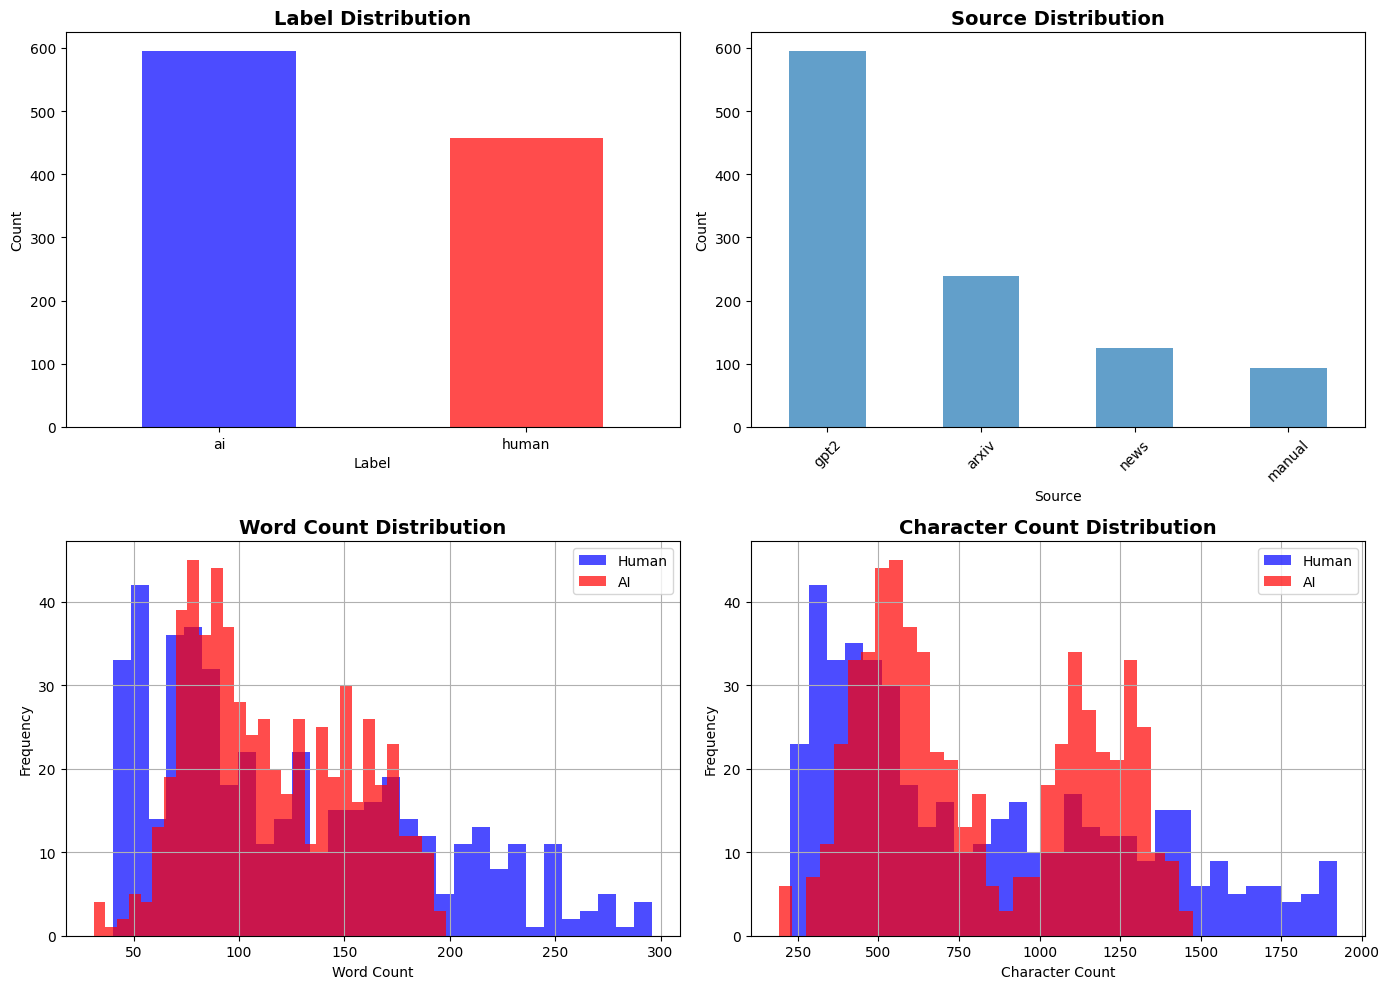

✅ Visualization saved


In [ ]:
# ============================================
# VISUALIZE DATASET
# ============================================

print("Creating visualizations...")

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Label distribution
ax1 = axes[0, 0]
df['label'].value_counts().plot(kind='bar', ax=ax1, color=['blue', 'red'], alpha=0.7)
ax1.set_title('Label Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

# Plot 2: Source distribution
ax2 = axes[0, 1]
df['source'].value_counts().plot(kind='bar', ax=ax2, alpha=0.7)
ax2.set_title('Source Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Source')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Word count distribution
ax3 = axes[1, 0]
df[df['label']=='human']['word_count'].hist(bins=30, alpha=0.7, label='Human', color='blue', ax=ax3)
df[df['label']=='ai']['word_count'].hist(bins=30, alpha=0.7, label='AI', color='red', ax=ax3)
ax3.set_title('Word Count Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Word Count')
ax3.set_ylabel('Frequency')
ax3.legend()

# Plot 4: Char count distribution
ax4 = axes[1, 1]
df[df['label']=='human']['char_count'].hist(bins=30, alpha=0.7, label='Human', color='blue', ax=ax4)
df[df['label']=='ai']['char_count'].hist(bins=30, alpha=0.7, label='AI', color='red', ax=ax4)
ax4.set_title('Character Count Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Character Count')
ax4.set_ylabel('Frequency')
ax4.legend()

plt.tight_layout()
plt.savefig(f'{project_dir}/results/dataset_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved")